**Importing Modules**

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
%matplotlib inline

**Using pretrained InceptionV3**

In [ ]:
base_model=tf.keras.applications.VGG19(include_top=False,weights="imagenet",input_shape=(512,512,3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable=True
for layer in base_model.layers:
  layer.trainable=False
  if layer.name=='block5_conv3':
    layer.trainable=False
    break

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

**Adding top layers**

In [ ]:
def myModel():
  last_layer=base_model.get_layer('block5_pool')
  base_model_output=last_layer.output
  # model=tf.keras.Sequential()
  x=layers.Conv2D(512,(2,2),strides=(2,2),activation='relu')(base_model_output)
  x=layers.Conv2D(128,(1,1))(x)
  x=layers.LeakyReLU(alpha=0.1)(x)
  x=layers.Conv2D(64,(1,1))(x)
  x=layers.LeakyReLU(alpha=0.1)(x)
  second_last_output=x
  box1_object=layers.Conv2D(1,(1,1),activation='sigmoid')(x)
  box1_centre=layers.Conv2D(2,(1,1),activation='sigmoid')(x)
  box1_dimensions=layers.Conv2D(2,(1,1),activation='sigmoid')(x)
  box1_class=layers.Conv2D(20,(1,1),activation='sigmoid')(x)

  box2_object=layers.Conv2D(1,(1,1),activation='sigmoid')(x)
  box2_centre=layers.Conv2D(2,(1,1),activation='sigmoid')(x)
  box2_dimensions=layers.Conv2D(2,(1,1),activation='sigmoid')(x)
  box2_class=layers.Conv2D(20,(1,1),activation='sigmoid')(x)
  output=tf.concat([box1_object,box1_centre,box1_dimensions,box1_class,box2_object,box2_centre,box2_dimensions,box2_class],axis=3)
  return tf.keras.models.Model(inputs=base_model.input,outputs=output)


**Creating loss function**

In [ ]:
binary_loss=tf.keras.losses.BinaryCrossentropy()
mse=tf.keras.losses.MeanSquaredError()
def loss_function(target,predicted):
  target=target[0]
  predicted=predicted[0]
  box1_detection=binary_loss(target[:,:,0],predicted[:,:,0])
  box1_centre_loss=mse(target[:,:,0]*target[:,:,1],target[:,:,0]*predicted[:,:,1])
  box1_centre_loss+=mse(target[:,:,0]*target[:,:,2],target[:,:,0]*predicted[:,:,2])
  box1_sides_loss=mse(target[:,:,0]*(target[:,:,3]),target[:,:,0]*(predicted[:,:,3]))
  box1_sides_loss+=mse(target[:,:,0]*(target[:,:,4]),target[:,:,0]*(predicted[:,:,4]))
  box1_class_loss=0
  for i in range(5,25):
    box1_class_loss+=mse(target[:,:,0]*target[:,:,i],target[:,:,0]*predicted[:,:,i])
  
  box2_detection=binary_loss(target[:,:,25],predicted[:,:,25])
  box2_centre_loss=mse(target[:,:,25]*target[:,:,26],target[:,:,25]*predicted[:,:,26])
  box2_centre_loss+=mse(target[:,:,25]*target[:,:,27],target[:,:,25]*predicted[:,:,27])
  box2_sides_loss=mse(target[:,:,25]*(target[:,:,28]),target[:,:,25]*(predicted[:,:,28]))
  box2_sides_loss+=mse(target[:,:,25]*(target[:,:,29]),target[:,:,25]*(predicted[:,:,29]))
  box2_class_loss=0
  for i in range(30,50):
    box2_class_loss+=mse(target[:,:,25]*target[:,:,i],target[:,:,25]*predicted[:,:,i])
  
  total_loss=(box1_detection+box1_centre_loss+box1_sides_loss+box1_class_loss+box2_detection+box2_centre_loss+box2_sides_loss+0.2*box2_class_loss)
  return total_loss


**Getting Data**

In [ ]:
windows=[]
for i in range(1,65):
  path='/content/drive/My Drive/Windows_files/window'+str(i)+'.csv'
  windows.append(pd.read_csv(path))

In [ ]:
img_names=[]

In [ ]:
print(len(windows))

64


In [ ]:
def find_coordinates_from_centre(x,y,width,height):
  x_top=x-width//2
  x_bottom=x+width//2
  y_top=y-height//2
  y_bottom=y+height//2
  return int(x_top),int(y_top),int(x_bottom),int(y_bottom)

def find_row_and_column(cell):
  cell=cell-1
  row=cell//8
  column=cell%8
  return row,column

def visualize(x,y,width,height,cell,img):
  width=int(width*512)
  height=int(height*512)
  print(width,height)
  x=int(x*64)
  y=int(y*64)
  row,column=find_row_and_column(cell) #starting from 1
  x=column*64+x
  y=row*64+y
  x_top,y_top,x_bottom,y_bottom=find_coordinates_from_centre(x,y,width,height)
  print(x_top,y_top,x_bottom,y_bottom)
  cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),(255,255,0),1)
  plt.figure(figsize=(12,12))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))



In [ ]:
def get_labels_for_an_image(i):
    img_names.append(windows[0].loc[i][1])
    for j in range(3,53):  
      if j==3:
        x=np.zeros((8,8))
        for k in range(64):
          r,c=find_row_and_column(k+1)
          x[r][c]=windows[k].loc[i][j]
        x=x.reshape(8,8,1) 
      else:
        y=np.zeros((8,8))
        for k in range(64):
          r,c=find_row_and_column(k+1)
          y[r][c]=windows[k].loc[i][j]
        y=y.reshape(8,8,1)
        x=np.dstack((x,y))
    return tf.Variable(x)
          

In [ ]:
def get_labels():
  for i in range(100):
    if i%10==0:
      print(f'Working on {i} file')
    if i==0:
      x=get_labels_for_an_image(i)
      x=tf.reshape(x,[1,8,8,50])
    else:
      y=get_labels_for_an_image(i)
      y=tf.reshape(y,[1,8,8,50])
      x=tf.concat([x,y],axis=0)
  return x


In [ ]:
result=get_labels()
print(result.shape)

Working on 0 file
Working on 10 file
Working on 20 file
Working on 30 file
Working on 40 file
Working on 50 file
Working on 60 file
Working on 70 file
Working on 80 file
Working on 90 file
(100, 8, 8, 50)


In [ ]:
def import_images(img_names):
  for i in range(100):
    if(i%10==0):
      print(f'On {i} file')
    path='/content/drive/My Drive/Images/'+img_names[i]
    if i==0:
      images=cv2.imread(path,1).reshape(1,512,512,3)
    else:
      y=cv2.imread(path,1).reshape(1,512,512,3)
      images=tf.concat([images,y],axis=0)
  return images

In [ ]:
images=import_images(img_names)

On 0 file
On 10 file
On 20 file
On 30 file
On 40 file
On 50 file
On 60 file
On 70 file
On 80 file
On 90 file


In [ ]:
images.shape

TensorShape([100, 512, 512, 3])

**Training**

In [ ]:
X=cv2.imread('/content/drive/My Drive/yolo_img_sample/2007_000033.jpg',1).reshape(1,512,512,3)

In [ ]:
model=myModel()
model.compile(optimizer='adam',loss=loss_function)
model.fit(images[1:100,:,:,:]/255,result[1:100,:,:,:],epochs=150)

Epoch 1/150
4/4 [==============================] - 7s 2s/step - loss: 1.4651
Epoch 2/150
4/4 [==============================] - 4s 1s/step - loss: 0.4783
Epoch 3/150
4/4 [==============================] - 4s 1s/step - loss: 0.6318
Epoch 4/150
4/4 [==============================] - 4s 1s/step - loss: 0.4696
Epoch 5/150
4/4 [==============================] - 4s 1s/step - loss: 0.4511
Epoch 6/150
4/4 [==============================] - 4s 1s/step - loss: 0.3322
Epoch 7/150
4/4 [==============================] - 4s 1s/step - loss: 0.4041
Epoch 8/150
4/4 [==============================] - 4s 1s/step - loss: 0.1693
Epoch 9/150
4/4 [==============================] - 4s 1s/step - loss: 0.1865
Epoch 10/150
4/4 [==============================] - 4s 1s/step - loss: 0.2806
Epoch 11/150
4/4 [==============================] - 4s 1s/step - loss: 0.2281
Epoch 12/150
4/4 [==============================] - 4s 1s/step - loss: 0.1962
Epoch 13/150
4/4 [==============================] - 4s 1s/step - loss: 0.

In [ ]:
def show_boxes(img,outputs):
  for i in range(1,65):
    r,c=find_row_and_column(i)
    if(outputs[r][c][0]>0.5):
      x,y,width,height=float(outputs[r][c][1]),float(outputs[r][c][2]),float(outputs[r][c][3]),float(outputs[r][c][4])
      width=int(width*512)
      height=int(height*512)
      x=int(x*64)
      y=int(y*64)
      row,column=find_row_and_column(i) #starting from 1
      x=column*64+x
      y=row*64+y
      x_top,y_top,x_bottom,y_bottom=find_coordinates_from_centre(x,y,width,height)
      cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),(255,0,0),2)
    if(outputs[r][c][25]>0.5):
      x,y,width,height=float(outputs[r][c][26]),float(outputs[r][c][27]),float(outputs[r][c][28]),float(outputs[r][c][29])
      width=int(width*512)
      height=int(height*512)
      x=int(x*64)
      y=int(y*64)
      row,column=find_row_and_column(i) #starting from 1
      x=column*64+x
      y=row*64+y
      x_top,y_top,x_bottom,y_bottom=find_coordinates_from_centre(x,y,width,height)
      cv2.rectangle(img,(x_top,y_top),(x_bottom,y_bottom),(0,0,255),2)
  cv2_imshow(img)



In [ ]:
num=58
path='/content/drive/My Drive/Images/'
show_boxes(cv2.imread(path+img_names[num],1),result[num])

NameError: ignored

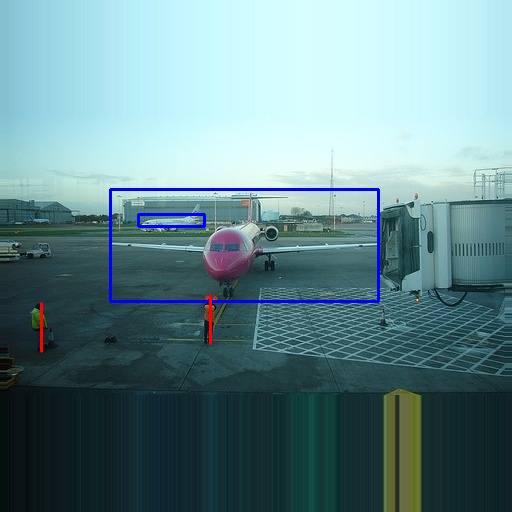

In [ ]:
show_boxes(cv2.imread('/content/drive/My Drive/yolo_img_sample/2007_000032.jpg',1).reshape(512,512,3),model((cv2.imread('/content/drive/My Drive/yolo_img_sample/2007_000032.jpg',1)/255).reshape(1,512,512,3))[0])

In [ ]:
def area(x_top,y_top,x_bottom,y_bottom):
  w=max(x_bottom-x_top,0)
  h=max(y_bottom-y_top,0)
  return w*h
  
def IOU(rect11,rect12,rect21,rect22):
  x_top1,y_top1=rect11
  x_bottom1,y_bottom1=rect12
  x_top2,y_top2=rect21
  x_bottom2,y_bottom2=rect22
  x_top_iou=max(x_top1,x_top2)
  y_top_iou=max(y_top1,y_top2)
  x_bottom_iou=min(x_bottom1,x_bottom2)
  y_bottom_iou=min(y_bottom1,y_bottom2)
  area_i=area(x_top_iou,y_top_iou,x_bottom_iou,y_bottom_iou)
  area_u=area(x_top1,y_top1,x_bottom1,y_bottom1)+area(x_top2,y_top2,x_bottom2,y_bottom2)-area_i
  return float(area_i/area_u)


**Custom Training**

In [ ]:
@tf.function
def train_step(model,img,target):
  with tf.GradientTape() as tape:
    pred=model(image,training=True)
    

In [ ]:
a=tf.constant(np.random.rand(1,512,512,4))
b=tf.constant(np.random.rand(1,512,512,3))

In [ ]:
tf.concat([a,b],axis=3)

<tf.Tensor: shape=(1, 512, 512, 7), dtype=float64, numpy=
array([[[[0.85230886, 0.31990016, 0.85098003, ..., 0.55322986,
          0.58207067, 0.55132389],
         [0.35360161, 0.04621057, 0.13463199, ..., 0.17194842,
          0.67579462, 0.6213869 ],
         [0.08565207, 0.10817003, 0.4087379 , ..., 0.70772565,
          0.74627536, 0.78552301],
         ...,
         [0.726782  , 0.6323939 , 0.96866656, ..., 0.90943695,
          0.69074024, 0.89372533],
         [0.67889764, 0.28208155, 0.69122021, ..., 0.47750268,
          0.61702394, 0.01534489],
         [0.96043711, 0.81495434, 0.00230547, ..., 0.55721248,
          0.32030325, 0.84340924]],

        [[0.82877623, 0.84581751, 0.73405429, ..., 0.94633326,
          0.72752829, 0.76900312],
         [0.29098163, 0.04241438, 0.36775873, ..., 0.04216513,
          0.70093904, 0.5230521 ],
         [0.76276456, 0.69826185, 0.7434435 , ..., 0.91685158,
          0.57122865, 0.17769658],
         ...,
         [0.03529092, 0.447581